# Project Title
Predicting probability of death from heart disease based on different risk factors
# Project Proposal
Using  Heart Failure Clinical Data databases, our goal is to identify which risk factors are more strongly related to the death from heart disease, and develop a model to predict the probability of death due to heart disease using these risk factors.
# Reference to Data Sources

## Heart Failure Clinical Data
Creator
Davide Chicco, Giuseppe Jurman: Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Medical Informatics and Decision Making 20, 16 (2020).
Original Publication
https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5

*Link*
https://www.kaggle.com/andrewmvd/heart-failure-clinical-data

# Project Codes

### Load Packages

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

### Load Data
>The heart failure clinical data dataset contains 13 fields that can be used to predict the mortality probability from heart failure in patients admitted to the hospital. It provides biological indicators as well as behavioral risk factors such as if a patient is a smoker. This dataset can be also used to determine the mortality of patients with heart disease and it would be interesting to see the relationship between tables and variables.

In [4]:
'''
Ejection fraction (EF) is a measurement, expressed as a percentage, of how much blood the left ventricle pumps out 
with each contraction. An ejection fraction of 60 percent means that 60 percent of the total amount of blood in the 
left ventricle is pushed out with each heartbeat.

A serum creatinine test measures the level of creatinine in your blood and provides an estimate of how well your 
kidneys filter (glomerular filtration rate).
'''

clinical = pd.read_csv('heart_failure_clinical_data.csv')
clinical.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### Exploratory data analysis

#### Gender
> Within our clinical records, there are much more male patients (65%) with heart failure than female patients(35%).

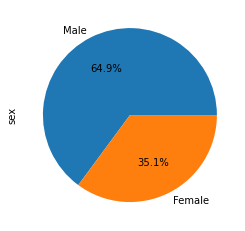

In [77]:
clinical.sex.value_counts().plot(kind='pie', labels={'Female', 'Male'}, autopct='%1.1f%%')

#### Creatinine Phosphokinase
>The typical range of Creatinine Phosphokinase for heart disease patients are usually within (0, 250) or around 600.

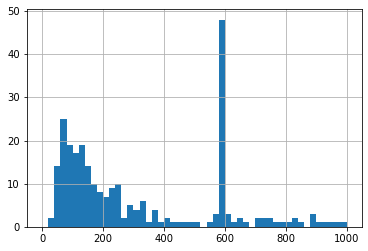

In [92]:
clinical.creatinine_phosphokinase.hist(bins=50,range=(0, 1000))

#### Age
> The age histogram below shows that the patients within the age group [54,61] are more likely to have heart failure. However, as the age grows, patients will have higher and higher chance of dying from the disease.

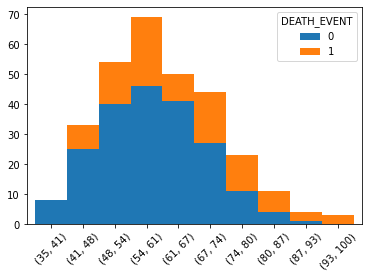

In [138]:
def hist(x):
    h, e = np.histogram(x.dropna(), range=(35, 100))
    e = e.astype(int)
    return pd.Series(h, zip(e[:-1], e[1:]))

kw = dict(stacked=True, width=1, rot=45)
clinical.groupby('DEATH_EVENT').age.apply(hist).unstack(0).plot.bar(**kw)

#### Serum Creatinine
> The Serum Creatinine histogram below shows that the patients with higher SC value will have higher mortality rate.

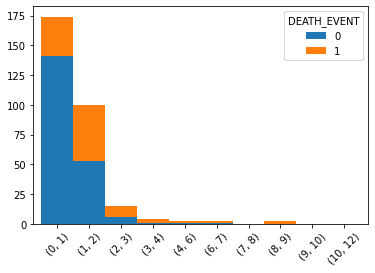

In [154]:
def hist(x):
    h, e = np.histogram(x.dropna(), range=(0, 12))
    e = e.astype(int)
    return pd.Series(h, zip(e[:-1], e[1:]))

kw = dict(stacked=True, width=1, rot=45)
clinical.groupby('DEATH_EVENT').serum_creatinine.apply(hist).unstack(0).plot.bar(**kw)

#### Anaemia
>The impact of anaemia on death: The patients having anaemia has higher chance of death than these without as 35.7% > 29.4%

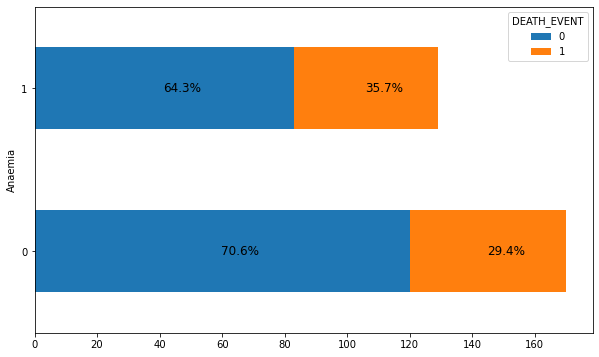

In [82]:
anaemia = clinical.groupby('anaemia')['DEATH_EVENT'].value_counts()[1]
non_anaemia = clinical.groupby('anaemia')['DEATH_EVENT'].value_counts()[0]
anaemia = anaemia*(100/anaemia.sum())
non_anaemia = non_anaemia*(100/non_anaemia.sum())
df2 = pd.DataFrame(np.array([list(anaemia), list(non_anaemia)]), index = ['anaemia', 'non_anaemia'], columns = ['No', 'Yes'])

ax = clinical.groupby('anaemia')['DEATH_EVENT'].value_counts().unstack(level=1).plot.barh(stacked=True, figsize=(10, 6))
ax.set_ylabel("Anaemia")

# Set txt
kx = -0.3
ky = -0.02

values = [70.58823529411765, 64.34108527131784, 29.411764705882355, 35.65891472868217]

for i,rec in enumerate(ax.patches):
    ax.text(rec.get_xy()[0]+rec.get_width()/2+kx,rec.get_xy()[1]+rec.get_height()/2+ky,'{:.1%}'.format(values[i]/100), fontsize=12, color='black')

#### Diabetes
> Diabetes has little impact on the death rate of heart failure, as the patients with or without diabetes are having approximately the same probability of death

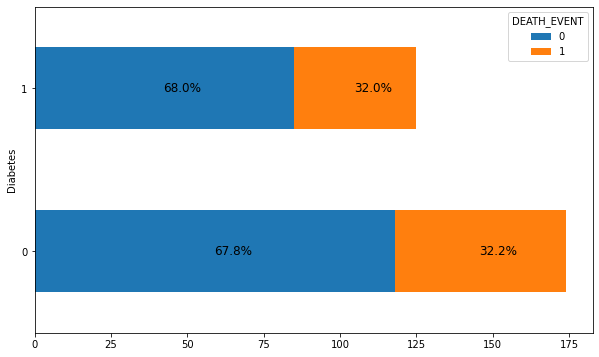

In [81]:
diabetes = clinical.groupby('diabetes')['DEATH_EVENT'].value_counts()[1]
non_diabetes = clinical.groupby('diabetes')['DEATH_EVENT'].value_counts()[0]
diabetes = diabetes*(100/diabetes.sum())
non_diabetes = non_diabetes*(100/non_diabetes.sum())
df2 = pd.DataFrame(np.array([list(anaemia), list(non_anaemia)]), index = ['diabetes', 'non_diabetes'], columns = ['No', 'Yes'])

ax = clinical.groupby('diabetes')['DEATH_EVENT'].value_counts().unstack(level=1).plot.barh(stacked=True, figsize=(10, 6))
ax.set_ylabel("Diabetes")

# Set txt
kx = -0.3
ky = -0.02

values = [67.816092, 68.000000, 32.183908, 32.000000]

for i,rec in enumerate(ax.patches):
    ax.text(rec.get_xy()[0]+rec.get_width()/2+kx,rec.get_xy()[1]+rec.get_height()/2+ky,'{:.1%}'.format(values[i]/100), fontsize=12, color='black')

#### Smoking
> Smoking has little impact on the mortality rate of heart failure, as the patients with or without smoking habit are having approximately the same probability of death

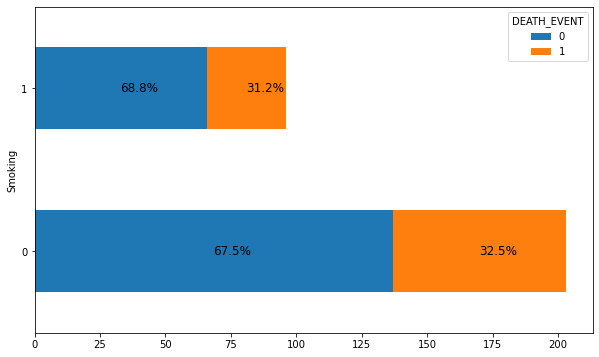

In [80]:
smoking = clinical.groupby('smoking')['DEATH_EVENT'].value_counts()[1]
non_smoking = clinical.groupby('smoking')['DEATH_EVENT'].value_counts()[0]
smoking = smoking*(100/smoking.sum())
non_smoking = non_smoking*(100/non_smoking.sum())
df2 = pd.DataFrame(np.array([list(smoking), list(non_smoking)]), index = ['smoking', 'non_smoking'], columns = ['No', 'Yes'])

ax = clinical.groupby('smoking')['DEATH_EVENT'].value_counts().unstack(level=1).plot.barh(stacked=True, figsize=(10, 6))
ax.set_ylabel("Smoking")

# Set txt
kx = -0.3
ky = -0.02

values = [67.487685, 68.750000, 32.512315, 31.250000]

for i,rec in enumerate(ax.patches):
    ax.text(rec.get_xy()[0]+rec.get_width()/2+kx,rec.get_xy()[1]+rec.get_height()/2+ky,'{:.1%}'.format(values[i]/100), fontsize=12, color='black')

#### High Blood Pressure
>The impact of high blood pressure on death: The patients having high blood pressure are more likely to die from heart disease than these without as 37.1% > 29.4%

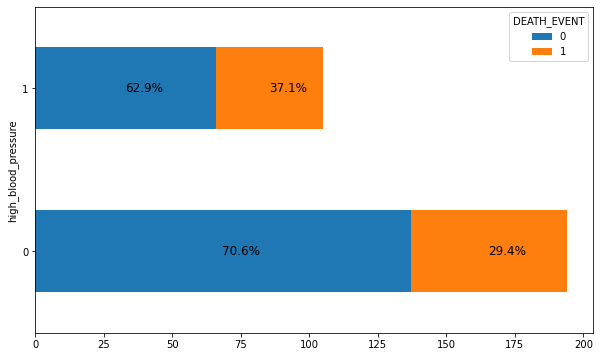

In [85]:
high_blood_pressure = clinical.groupby('high_blood_pressure')['DEATH_EVENT'].value_counts()[1]
non_high_blood_pressure = clinical.groupby('high_blood_pressure')['DEATH_EVENT'].value_counts()[0]
high_blood_pressure = high_blood_pressure*(100/high_blood_pressure.sum())
non_high_blood_pressure = non_high_blood_pressure*(100/non_high_blood_pressure.sum())
df2 = pd.DataFrame(np.array([list(high_blood_pressure), list(non_high_blood_pressure)]), index = ['high_blood_pressure', 'non_high_blood_pressure'], columns = ['No', 'Yes'])

ax = clinical.groupby('high_blood_pressure')['DEATH_EVENT'].value_counts().unstack(level=1).plot.barh(stacked=True, figsize=(10, 6))
ax.set_ylabel("high_blood_pressure")

# Set txt
kx = -0.3
ky = -0.02

values = [70.618557, 62.857143, 29.381443, 37.142857]

for i,rec in enumerate(ax.patches):
    ax.text(rec.get_xy()[0]+rec.get_width()/2+kx,rec.get_xy()[1]+rec.get_height()/2+ky,'{:.1%}'.format(values[i]/100), fontsize=12, color='black')

### Model Training

In [141]:
clinical = clinical.loc[:, clinical.columns != 'time']
X = clinical.loc[:, clinical.columns != 'DEATH_EVENT']
y = clinical.loc[:, clinical.columns == 'DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [142]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/kiki.wang/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()

In [143]:
import pickle
pickle.dump(logreg, open('logreg_model.sav', 'wb'))

### Model Evaluation

In [144]:
logreg = pickle.load(open('logreg_model.sav', 'rb'))

In [145]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.75


In [146]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[38  4]
 [11  7]]


In [147]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84        42
           1       0.64      0.39      0.48        18

    accuracy                           0.75        60
   macro avg       0.71      0.65      0.66        60
weighted avg       0.73      0.75      0.73        60



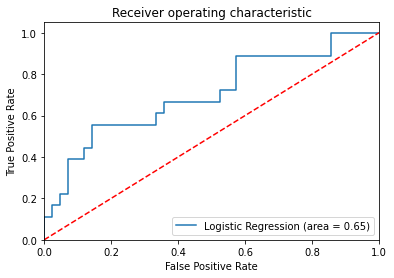

In [148]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

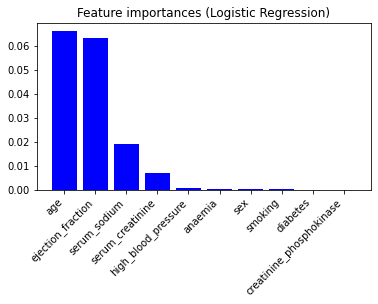

In [149]:
coefs = np.abs(logreg.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Logistic Regression)")
plt.bar(range(10), coefs[indices[:10]],
       color="b", align="center")
plt.xticks(range(10), clinical.columns[indices[:10]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

### Conclusion
With limited 300 data, our logistic model still captured some insights from the data. It provided a reasonable prediction of mortality probability for patients with heart disease with accuracy as high as 0.75. The feature importance plot shows that age, ejection fraction, serum sodium value, serum creatinine and high blood pressure are useful features for prediction, which is consistent with our EDA results.